# W261 Final Project - Experiment, Fine-Tune, Select the Optimal Pipeline (Coding Notebook - MLP Model)
## Section 02, Team 1: Aimee, Dylan, Jo, Vicky

In [0]:
# read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

# Read the checkpointed train and test datasets
df_train_downsampled = spark.read.parquet(f"{folder_path}/df_train_downsampled.parquet")
df_test = spark.read.parquet(f"{folder_path}/df_test.parquet")
df_train = spark.read.parquet(f"{folder_path}/df_train.parquet")

# Setup & Directory

In [0]:
# Basic Functions
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
 
# For feature engineering
from pyspark.ml.feature import StandardScaler, VectorAssembler, VectorIndexer, StringIndexer, OneHotEncoder, ChiSqSelector, Bucketizer, Imputer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
 
# For EDA/plotting & basic funcs
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1, style='whitegrid')
import random
from math import floor
 
# For Modeling
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import classification_report
import itertools 
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier


In [0]:
# read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

df_otpw_3m = spark.read.parquet(f"{folder_path}/otpw_3m_proceed.parquet")
df_otpw_12m = spark.read.parquet(f"{folder_path}/otpw_12m_proceed.parquet")

# Train-Test Split on 3 Month / 12 Month Data

In [0]:
# Train-Test Split based on the last 3 months of the year
df_train_3m = df_otpw_3m.filter(col("DATE") < "2015-03-01 00:00:00")  # Data before March 1, 2015
df_test_3m = df_otpw_3m.filter(col("DATE") >= "2015-03-01 00:00:00")  # Data from March 1, 2015, onwards

print("Training Set Size:", df_train_3m.count())
print("Test Set Size:", df_test_3m.count())

Training Set Size: 865226
Test Set Size: 492688


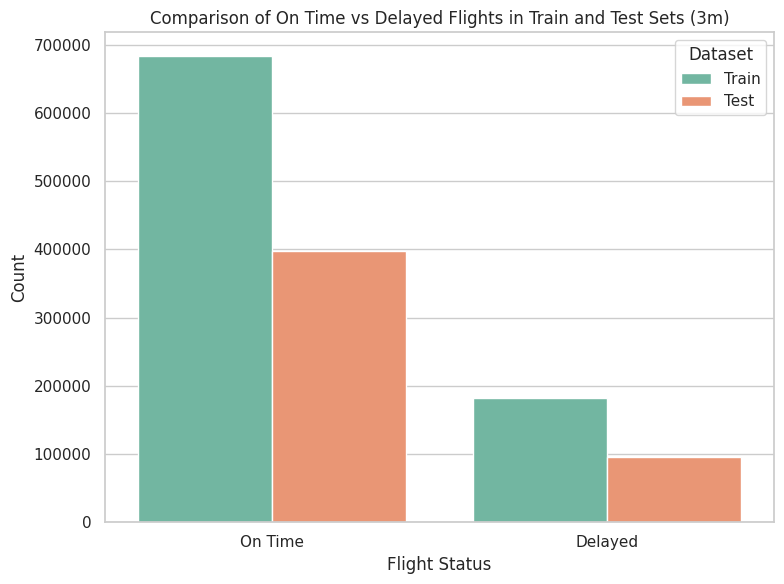

In [0]:

# Convert to Pandas DataFrame for visualization
df_train_3m_pandas = df_train_3m.toPandas()
df_test_3m_pandas = df_test_3m.toPandas()

# Create a new column for the dataset split (train or test) in both dataframes
df_train_3m_pandas['Dataset'] = 'Train'
df_test_3m_pandas['Dataset'] = 'Test'

# Concatenate the two datasets to combine them for plotting
df_combined = pd.concat([df_train_3m_pandas[['DEP_DEL15', 'Dataset']], df_test_3m_pandas[['DEP_DEL15', 'Dataset']]])

# Replace 0 with 'On Time' and 1 with 'Delayed' for better labeling
df_combined['DEP_DEL15'] = df_combined['DEP_DEL15'].replace({0: 'On Time', 1: 'Delayed'})

# Create a stacked bar plot to compare the distribution of On Time vs Delayed in both sets
plt.figure(figsize=(8, 6))
sns.countplot(x='DEP_DEL15', hue='Dataset', data=df_combined, palette='Set2')

# Set the title and labels
plt.title("Comparison of On Time vs Delayed Flights in Train and Test Sets (3m)")
plt.xlabel("Flight Status")
plt.ylabel("Count")
plt.legend(title='Dataset', loc='upper right')

plt.tight_layout()
plt.show()

In [0]:
# Train-Test Split based on the last 3 months of the year
df_train = df_otpw_12m.filter(col("DATE") < "2015-10-01 00:00:00")  # Data before October 1, 2015
df_test = df_otpw_12m.filter(col("DATE") >= "2015-10-01 00:00:00")  # Data from October 1, 2015, onwards

print("Training Set Size:", df_train.count())
print("Test Set Size:", df_test.count())

# Save the train-test splits
# df_train.write.mode("overwrite").parquet(f"{folder_path}/otpw_12m_train.parquet")
# df_test.write.mode("overwrite").parquet(f"{folder_path}/otpw_12m_test.parquet")


Training Set Size: 4305543
Test Set Size: 1416524


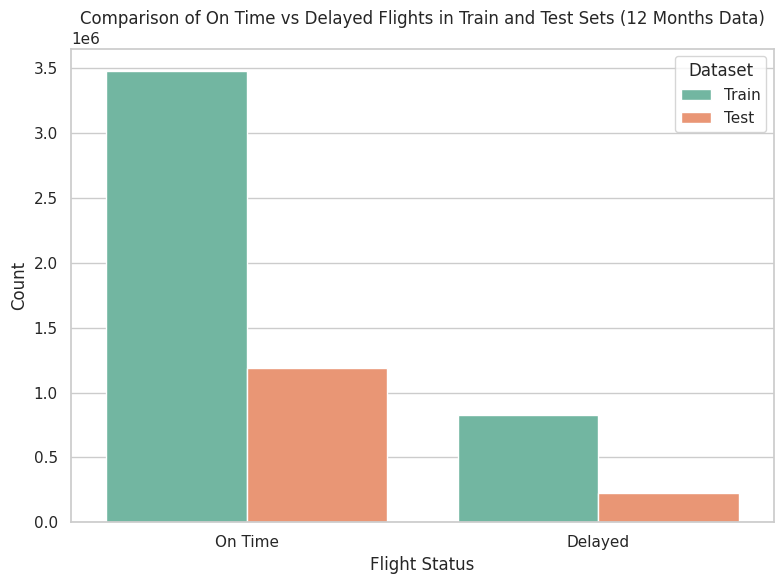

Count of On Time and Delayed flights in Train and Test sets:
DEP_DEL15  Delayed  On Time
Dataset                    
Test        227385  1189139
Train       826299  3479244


In [0]:
# Convert to Pandas DataFrame for visualization
df_train_pandas = df_train.toPandas()
df_test_pandas = df_test.toPandas()

# Create a new column for the dataset split (train or test) in both dataframes
df_train_pandas['Dataset'] = 'Train'
df_test_pandas['Dataset'] = 'Test'

# Concatenate the two datasets to combine them for plotting
df_combined_12m = pd.concat([df_train_pandas[['DEP_DEL15', 'Dataset']], df_test_pandas[['DEP_DEL15', 'Dataset']]])

# Replace 0 with 'On Time' and 1 with 'Delayed' for better labeling
df_combined_12m['DEP_DEL15'] = df_combined_12m['DEP_DEL15'].replace({0: 'On Time', 1: 'Delayed'})

# Create a stacked bar plot to compare the distribution of On Time vs Delayed in both sets
plt.figure(figsize=(8, 6))
sns.countplot(x='DEP_DEL15', hue='Dataset', data=df_combined_12m, palette='Set2')

# Set the title and labels
plt.title("Comparison of On Time vs Delayed Flights in Train and Test Sets (12 Months Data)")
plt.xlabel("Flight Status")
plt.ylabel("Count")
plt.legend(title='Dataset', loc='upper right')

plt.tight_layout()
plt.show()

# Count the occurrences of 0 and 1 for both train and test sets
count_table = df_combined_12m.groupby(['Dataset', 'DEP_DEL15']).size().unstack(fill_value=0)

# Display the count table
print("Count of On Time and Delayed flights in Train and Test sets:")
print(count_table)

#Downsampling

In [0]:
#downsampling 
def downsample(train_df,verbose=False):
  '''Downsamples train_df to balance classes'''
  #balance classes in train
  delay_count = train_df.filter(F.col("DEP_DEL15") == 1).count()
  non_delay_count = train_df.filter(F.col("DEP_DEL15") == 0).count()
 
  total = delay_count + non_delay_count
  keep_percent = delay_count / non_delay_count
  
  train_delay = train_df.filter(F.col('DEP_DEL15') == 1)
  train_non_delay = train_df.filter(F.col('DEP_DEL15') == 0).sample(withReplacement=False,fraction=keep_percent,seed=42)
  train_downsampled = train_delay.union(train_non_delay)
  return train_downsampled  

+---------+------+
|DEP_DEL15| count|
+---------+------+
|        1|181420|
|        0|181552|
+---------+------+



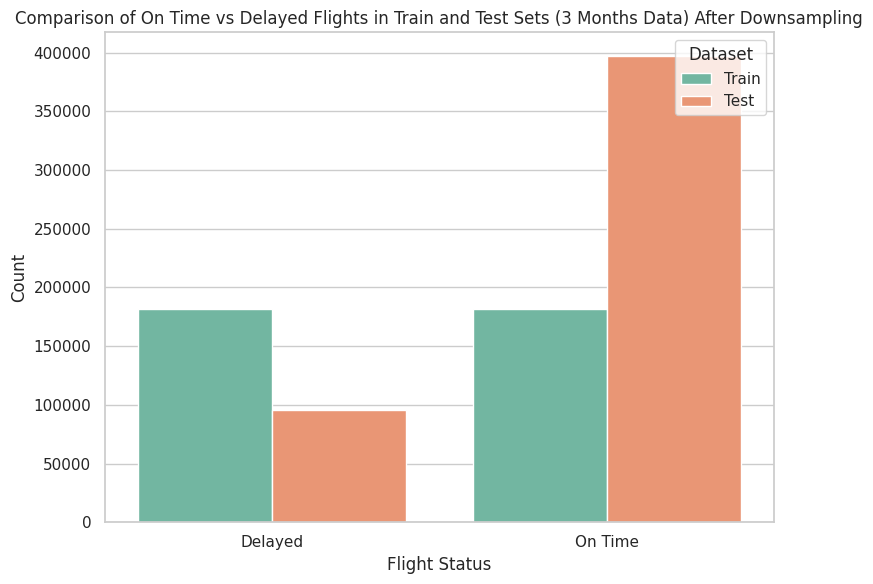

In [0]:
# Downsample the 3-month training data
df_train_3m_downsampled = downsample(df_train_3m)

# Check the distribution of DEP_DEL15 after downsampling
df_train_3m_downsampled.groupBy("DEP_DEL15").count().show()

# Convert to Pandas DataFrame for visualization
df_train_3m_downsampled_pandas = df_train_3m_downsampled.toPandas()
df_test_3m_pandas = df_test_3m.toPandas()

# Create a new column for dataset split (Train or Test)
df_train_3m_downsampled_pandas['Dataset'] = 'Train'
df_test_3m_pandas['Dataset'] = 'Test'

# Combine train and test data for visualization
df_combined_3m_downsampled = pd.concat([df_train_3m_downsampled_pandas[['DEP_DEL15', 'Dataset']], df_test_3m_pandas[['DEP_DEL15', 'Dataset']]])

# Replace 0 with 'On Time' and 1 with 'Delayed' for better labels
df_combined_3m_downsampled['DEP_DEL15'] = df_combined_3m_downsampled['DEP_DEL15'].replace({0: 'On Time', 1: 'Delayed'})

# Plot the distribution of On Time vs Delayed flights in train and test sets after downsampling
plt.figure(figsize=(8, 6))
sns.countplot(x='DEP_DEL15', hue='Dataset', data=df_combined_3m_downsampled, palette='Set2')

# Set the title and labels
plt.title("Comparison of On Time vs Delayed Flights in Train and Test Sets (3 Months Data) After Downsampling")
plt.xlabel("Flight Status")
plt.ylabel("Count")
plt.legend(title='Dataset', loc='upper right')

plt.tight_layout()
plt.show()

+---------+------+
|DEP_DEL15| count|
+---------+------+
|        1|826299|
|        0|826222|
+---------+------+



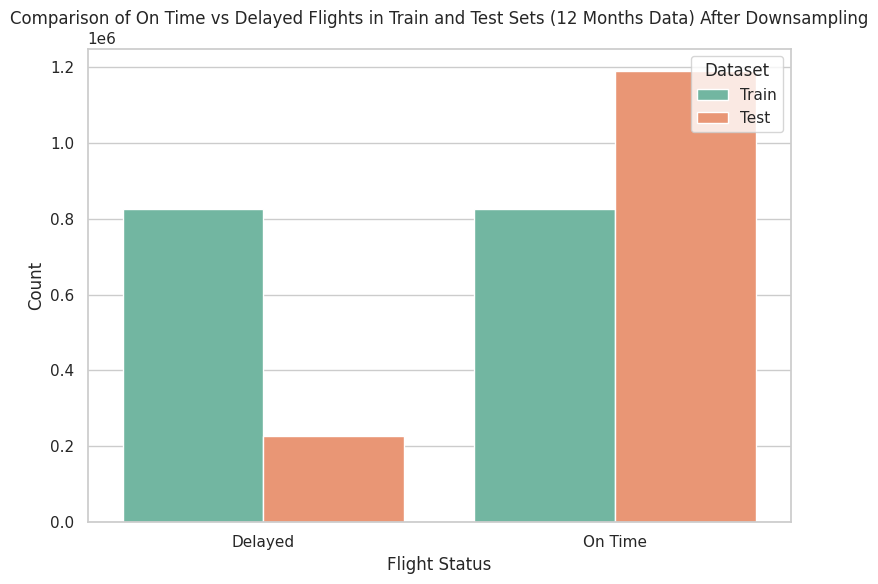

Count of On Time and Delayed flights in Train and Test sets (After Downsampling):
DEP_DEL15  Delayed  On Time
Dataset                    
Test        227385  1189139
Train       826299   826222


In [0]:
# Now, downsample the training data from the 12-month dataset
df_train_downsampled = downsample(df_train)
df_train_downsampled.groupBy("DEP_DEL15").count().show()
  
# Convert to Pandas DataFrame for visualization
df_train_downsampled_pandas = df_train_downsampled.toPandas()
df_test_pandas = df_test.toPandas()

# Create a new column for the dataset split (train or test) in both dataframes
df_train_downsampled_pandas['Dataset'] = 'Train'
df_test_pandas['Dataset'] = 'Test'

# Concatenate the two datasets to combine them for plotting
df_combined_12m_downsampled = pd.concat([df_train_downsampled_pandas[['DEP_DEL15', 'Dataset']], df_test_pandas[['DEP_DEL15', 'Dataset']]])

# Replace 0 with 'On Time' and 1 with 'Delayed' for better labeling
df_combined_12m_downsampled['DEP_DEL15'] = df_combined_12m_downsampled['DEP_DEL15'].replace({0: 'On Time', 1: 'Delayed'})

# Create a stacked bar plot to compare the distribution of On Time vs Delayed in both sets after downsampling
plt.figure(figsize=(8, 6))
sns.countplot(x='DEP_DEL15', hue='Dataset', data=df_combined_12m_downsampled, palette='Set2')

# Set the title and labels
plt.title("Comparison of On Time vs Delayed Flights in Train and Test Sets (12 Months Data) After Downsampling")
plt.xlabel("Flight Status")
plt.ylabel("Count")
plt.legend(title='Dataset', loc='upper right')

plt.tight_layout()
plt.show()

# Count the occurrences of 0 and 1 for both train and test sets after downsampling
count_table_downsampled = df_combined_12m_downsampled.groupby(['Dataset', 'DEP_DEL15']).size().unstack(fill_value=0)

# Display the count table for the downsampled dataset
print("Count of On Time and Delayed flights in Train and Test sets (After Downsampling):")
print(count_table_downsampled)

### MLP Neural Network

In [0]:
df_train_downsampled.dtypes

[('OP_CARRIER_AIRLINE_ID', 'string'),
 ('TAIL_NUM', 'string'),
 ('OP_CARRIER_FL_NUM', 'string'),
 ('ORIGIN_CITY_MARKET_ID', 'string'),
 ('ORIGIN', 'string'),
 ('ORIGIN_STATE_ABR', 'string'),
 ('DEST_CITY_MARKET_ID', 'string'),
 ('DEST', 'string'),
 ('DEST_STATE_ABR', 'string'),
 ('DEP_DELAY_NEW', 'double'),
 ('DEP_DEL15', 'int'),
 ('DIVERTED', 'string'),
 ('DISTANCE_GROUP', 'string'),
 ('origin_type', 'string'),
 ('dest_type', 'string'),
 ('dest_airport_lat', 'double'),
 ('sched_depart_date_time', 'timestamp'),
 ('sched_depart_date_time_UTC', 'timestamp'),
 ('four_hours_prior_depart_UTC', 'timestamp'),
 ('two_hours_prior_depart_UTC', 'timestamp'),
 ('STATION', 'string'),
 ('DATE', 'timestamp'),
 ('LATITUDE', 'double'),
 ('LONGITUDE', 'double'),
 ('HourlyDryBulbTemperature', 'double'),
 ('HourlyPrecipitation', 'double'),
 ('HourlyPressureTendency', 'double'),
 ('HourlyRelativeHumidity', 'double'),
 ('HourlySkyConditions', 'string'),
 ('HourlySeaLevelPressure', 'double'),
 ('HourlyStatio

In [0]:
def mlp_pipeline(model):
    """
    Optimized pipeline for neural network algorithms (MLP).
    """
    from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, FeatureHasher
    from pyspark.ml import Pipeline

    # Continuous features
    cont_feat = [
        'dest_airport_lat', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
        'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
        'HourlyStationPressure', 'HourlyVisibility', 'HourlyWindGustSpeed', 
        'HourlyWindSpeed', 'prev_flight_delay'
    ]

    assembler_cont = VectorAssembler(inputCols=cont_feat, outputCol="cont_features")

    # Categorical features
    columns_categorical = [
        'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM',  
        'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST_CITY_MARKET_ID', 'DEST', 
        'DEST_STATE_ABR', 'DIVERTED', 'DISTANCE_GROUP', 
        'origin_type', 'dest_type', 'STATION'
    ]

    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep") for c in columns_categorical]

    # Use FeatureHasher
    hasher = FeatureHasher(inputCols=[f"{c}_indexed" for c in columns_categorical], 
                           outputCol="hashed_features", numFeatures=500)

    # Assemble all features in one step
    assembler = VectorAssembler(inputCols=["cont_features", "hashed_features"], outputCol="features")

    # Define pipeline stages
    stages = [assembler_cont] + indexers + [hasher, assembler, model]

    pipeline = Pipeline(stages=stages)

    return pipeline

In [0]:
from xgboost.spark import SparkXGBClassifier

def get_model(model_type, pipeline_func, p):
  """
  Input: name of model, the pipeline function for that model and a set of parameters
  Output: a pipeline object for the input model type
  """
  if model_type == 'gbt':
    gbt = GBTClassifier(labelCol="DEP_DEL15",
                        featuresCol="features",
                        maxDepth=p["maxDepth"],
                        maxBins=p["maxBins"],
                        maxIter=p["maxIter"],
                        stepSize=p["stepSize"])
    pipeline = pipeline_func(gbt)
    
  elif model_type == 'xgboost':
    xgboost = SparkXGBClassifier(
        label_col="DEP_DEL15",  # Ensure this is the target column for classification (binary or multi-class labels)
        features_col="features",  # The feature column
        missing=0.0,
        raw_prediction_col='probability',  # This is for storing the prediction probabilities in classification tasks
        max_depth=p["max_depth"],
        n_estimators=p["n_estimators"],
        reg_lambda=p["reg_lambda"],
        reg_alpha=p["reg_alpha"],
        base_score=p["base_score"],
        learning_rate=p["learning_rate"],
        gamma=p["gamma"],
        min_child_weight=p["min_child_weight"],
        tree_method=p["tree_method"],  
        num_workers=p["num_workers"]   
    )
    pipeline = pipeline_func(xgboost)
  
  elif model_type == 'mlp':
    mlp = MultilayerPerceptronClassifier(labelCol="DEP_DEL15",
        featuresCol="features",
        layers=p["layers"],
        maxIter=p["maxIter"],
        blockSize=p["blockSize"],
        seed=p["seed"])
    pipeline = pipeline_func(mlp)
    
  return pipeline

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

def evaluate_classification_model(prediction, label_col="DEP_DEL15", prediction_col="prediction"):
    
    # Select predictions and actual labels
    predictions_and_labels = prediction.select(prediction_col, label_col)

    # For binary classification (precision, recall, F1):
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prediction_col)
    
    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()  # True Positive
    FP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()  # False Positive
    TN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()  # True Negative
    FN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()  # False Negative
    
    # Calculate evaluation metrics
    beta = 2
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) != 0 else 0.0
    roc_auc = binary_evaluator.setMetricName("areaUnderROC").evaluate(prediction)
    pr_auc = binary_evaluator.setMetricName("areaUnderPR").evaluate(prediction)

    # Create confusion matrix as a 2x2 array
    conf_matrix = np.array([[TN, FP], 
                            [FN, TP]])

    # Convert to Pandas DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                index=["Actual Negative (0)", "Actual Positive (1)"], 
                                columns=["Predicted Negative (0)", "Predicted Positive (1)"])

    # Plot the confusion matrix with color bar
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=True)  # cbar=True adds side bar
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    return precision, recall, f1_score, f2_score, roc_auc, pr_auc

In [0]:
# Cross-fold Validation

from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd

class BlockedTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, df):
        return self.n_splits

    def split(self, df):
        """
        Splits the dataset into train and validation sets based on time blocks.
        df is assumed to be a PySpark DataFrame containing both features and the target column.
        """
        # Ensure the DataFrame has a column for time (e.g., 'timestamp' or 'date') for ordering
        df_sorted = df.orderBy('DATE')  # Change 'timestamp' to your actual time column

        # Get the time range or indices for the split
        n_samples = df_sorted.count()
        split_size = n_samples // self.n_splits
        
        for i in range(self.n_splits):
            start_idx = i * split_size
            stop_idx = start_idx + split_size
            mid_idx = start_idx + int(0.8 * (stop_idx - start_idx))  # 80% train, 20% validation

            # Train: First 80% of the block
            train_data = df_sorted.limit(mid_idx)

            # Validation: Remaining 20% of the block
            val_data = df_sorted.subtract(train_data).limit(stop_idx - mid_idx)

            yield train_data, val_data


def cross_validate_with_blocked_time_series_split(models, df, n_splits):
    
    evaluator = BinaryClassificationEvaluator(labelCol="DEP_DEL15") 
    
    # Initialize the blocked time series split
    splitter = BlockedTimeSeriesSplit(n_splits)
    
    # Initialize dictionary to store evaluation results
    results = {model_name: {
        "precision": [],
        "recall": [],
        "f1_score": [],
        "f2_score": [],
        "roc_auc": [],
        "pr_auc": []
    } for model_name in models.keys()}
    
    # Cross-validation loop for each model
    for model_name, model in models.items():
        # Perform split and evaluate for each fold
        for train_data, val_data in splitter.split(df):
            # Create a pipeline for training
            pipeline = get_model(model_name, mlp_pipeline, model)  
            
            # Train the model using training data
            trained_model = pipeline.fit(train_data)
            
            # Make predictions on validation data
            predictions = trained_model.transform(val_data)
            
            # Evaluate the model with binary classification evaluator
            precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_classification_model(predictions)
            
            # Store the evaluation metrics for each fold
            results[model_name]["precision"].append(precision)
            results[model_name]["recall"].append(recall)
            results[model_name]["f1_score"].append(f1_score)
            results[model_name]["f2_score"].append(f2_score)
            results[model_name]["roc_auc"].append(roc_auc)
            results[model_name]["pr_auc"].append(pr_auc)

        for metric in results[model_name]:
            # Calculate the average of the metric across all folds
            results[model_name][metric] = np.mean(results[model_name][metric])
        
    return results



#### One Hidden Layer

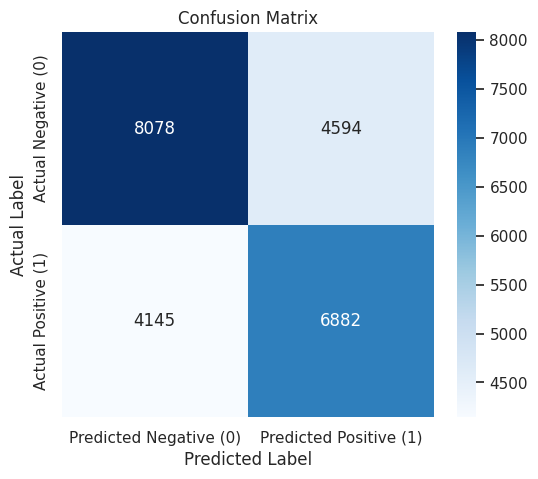

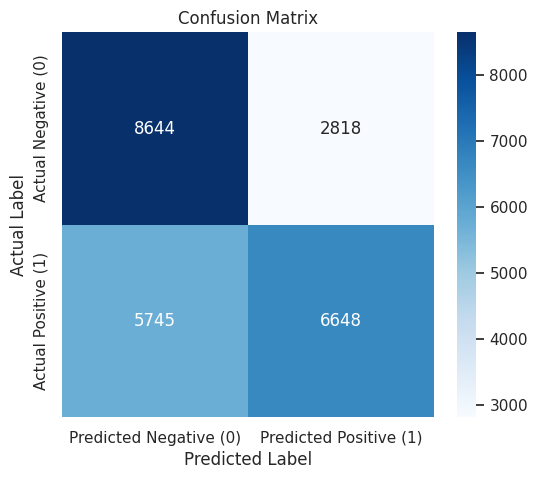

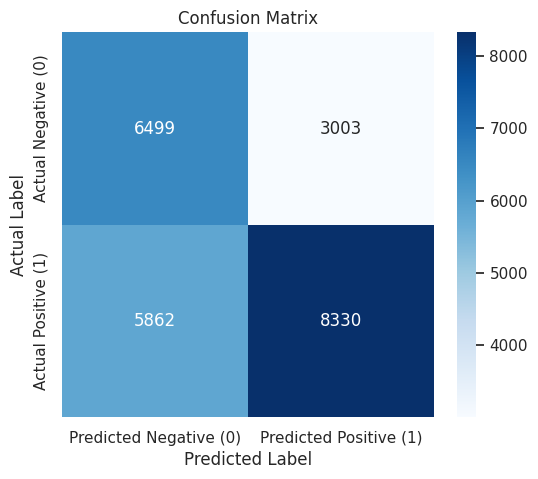

{'mlp': {'precision': 0.679003633071086,
  'recall': 0.5824955740420288,
  'f1_score': 0.6242024202210494,
  'f2_score': 0.597893949708841,
  'roc_auc': 0.6409907077387657,
  'pr_auc': 0.6537158149559193}}

In [0]:
# Cross-validation: MLP (One Hidden Layer)
p = {
    "maxIter": 100,
    "layers": [511, 128, 2],  # input, one hidden, output layer
    "blockSize": 128,
    "seed": 42
}

models = {'mlp': p}

# Perform cross-validation
df_train_3m_downsampled = df_train_3m_downsampled.dropna()
results = cross_validate_with_blocked_time_series_split(models, df_train_3m_downsampled, n_splits=3)
display(results)

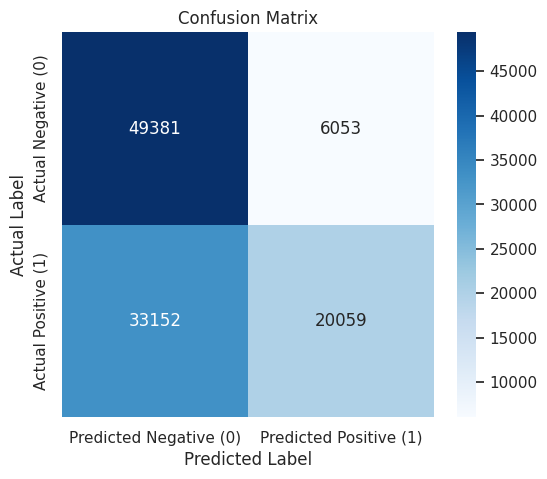

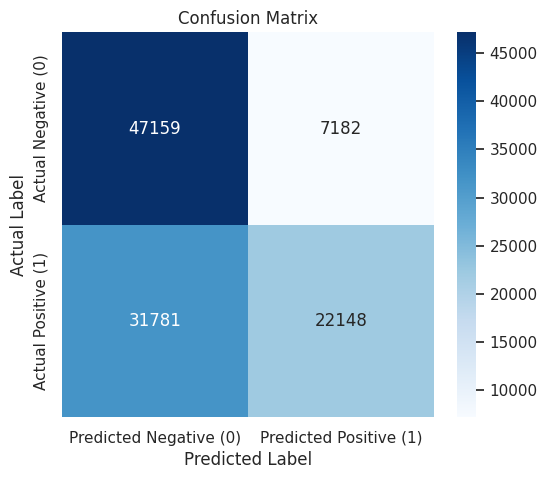

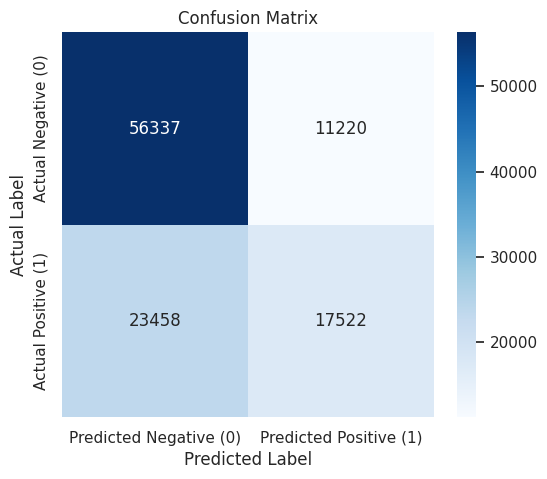

{'mlp': {'precision': 0.7109842136314679, 'recall': 0.40507782686508725, 'f1_score': 0.5134687428447935, 'f2_score': 0.4421236569098817, 'roc_auc': 0.635591914873107, 'pr_auc': 0.6353450459300333}}


In [0]:
# MLP using 12 month data
p = {
    "maxIter": 100,
    "layers": [511, 128, 2],  # input, one hidden, output layer
    "blockSize": 128,
    "seed": 42
}

models = {'mlp': p}

#'df_train' is the full dataframe containing both features and target columns
# Perform cross-validation
df_train_downsampled = df_train_downsampled.dropna().cache()
results = cross_validate_with_blocked_time_series_split(models, df_train_downsampled, n_splits=3)

print(results)

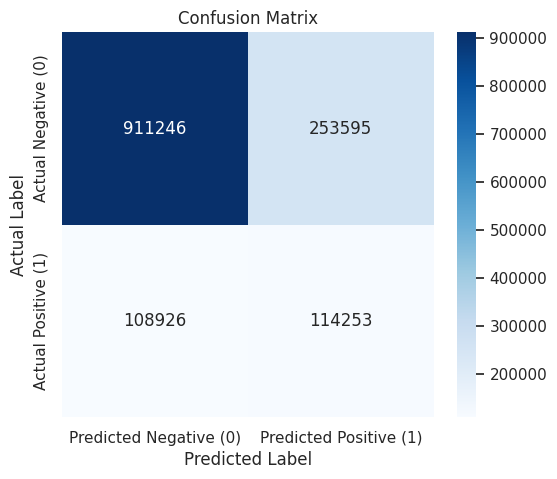

Precision: 0.31059839933885736
Recall: 0.5119343665846697
F1 Score: 0.386625314917931
F2 Score: 0.4531820677093745
ROC AUC: 0.6471132710416501
PR AUC: 0.27404010431806985


In [0]:
# After the model is selected, use the full training dataset for training and testing (12 month)

p = {
    "maxIter": 100,
    "layers": [511, 128, 2],  # input, one hidden, output layer
    "blockSize": 128,
    "seed": 42
}

model_type = 'mlp'
pipeline = get_model(model_type, mlp_pipeline, p)

mlp_model_12m = pipeline.fit(df_train_downsampled.dropna().cache())

prediction_mlp_12m = mlp_model_12m.transform(df_test.dropna().cache())

precision_mlp_12m, recall_mlp_12m, f1_score_mlp_12m, f2_score_mlp_12m, roc_auc_mlp_12m, pr_auc_mlp_12m = evaluate_classification_model(prediction_mlp_12m, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_mlp_12m}")
print(f"Recall: {recall_mlp_12m}")
print(f"F1 Score: {f1_score_mlp_12m}")
print(f"F2 Score: {f2_score_mlp_12m}")
print(f"ROC AUC: {roc_auc_mlp_12m}")
print(f"PR AUC: {pr_auc_mlp_12m}")

#### Two Hidden Layers

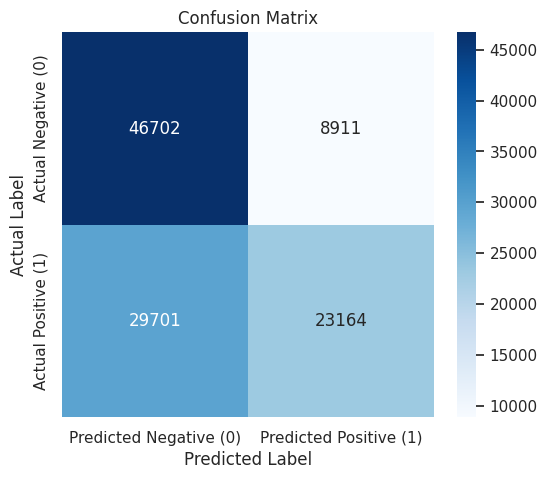

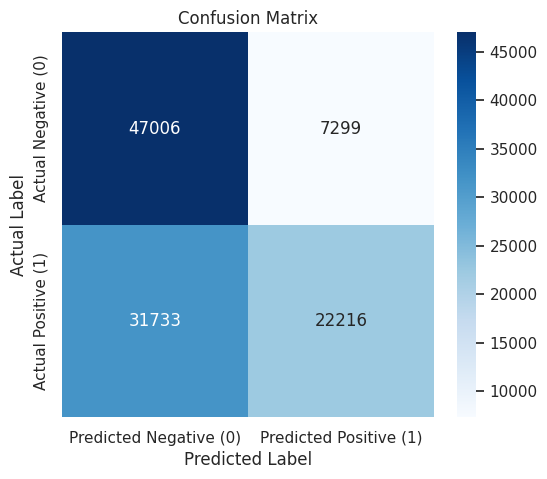

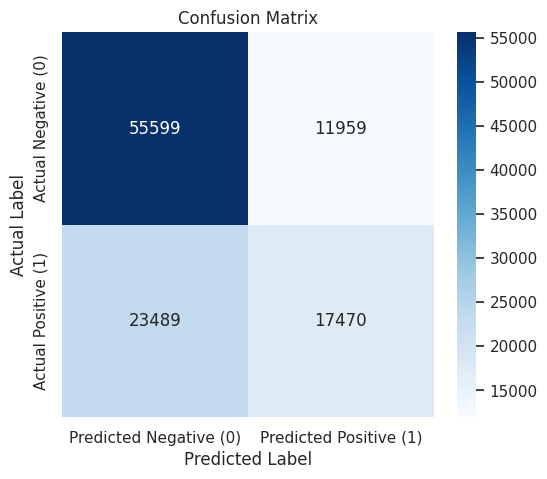

{'mlp': {'precision': 0.68950551084336, 'recall': 0.4254977050926891, 'f1_score': 0.524720334457388, 'f2_score': 0.46012050390049475, 'roc_auc': 0.6347780325761715, 'pr_auc': 0.6209665786810076}}


In [0]:
# MLP using 12 month data
p = {
    "maxIter": 100,
    "layers": [511, 128, 64, 2],  # input, two hidden, output layer
    "blockSize": 128,
    "seed": 42
}

models = {'mlp': p}

#'df_train' is the full dataframe containing both features and target columns
# Perform cross-validation
df_train_downsampled = df_train_downsampled.dropna().cache()
results = cross_validate_with_blocked_time_series_split(models, df_train_downsampled, n_splits=3)

print(results)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 541, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 564, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


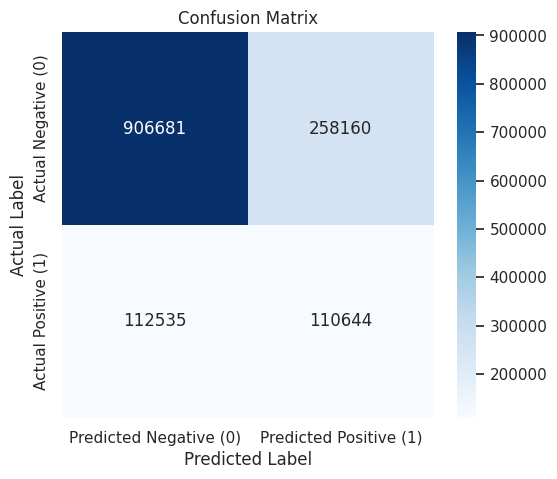

Precision: 0.30000759210854544
Recall: 0.49576349029254546
F1 Score: 0.37380803164955756
F2 Score: 0.43853446635804433
ROC AUC: 0.6370683379945671
PR AUC: 0.264908162091389


In [0]:
# After the model is selected, use the full training dataset for training and testing (12 month)

p = {
    "maxIter": 100,
    "layers": [511, 128, 64, 2],  # input, two hidden, output layer
    "blockSize": 128,
    "seed": 42
}

model_type = 'mlp'
pipeline = get_model(model_type, mlp_pipeline, p)

mlp_model_2h_12m = pipeline.fit(df_train_downsampled.dropna().cache())

prediction_mlp_2h_12m = mlp_model_2h_12m.transform(df_test.dropna().cache())

precision_mlp_2h_12m, recall_mlp_2h_12m, f1_score_mlp_2h_12m, f2_score_mlp_2h_12m, roc_auc_mlp_2h_12m, pr_auc_mlp_2h_12m = evaluate_classification_model(prediction_mlp_2h_12m, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_mlp_2h_12m}")
print(f"Recall: {recall_mlp_2h_12m}")
print(f"F1 Score: {f1_score_mlp_2h_12m}")
print(f"F2 Score: {f2_score_mlp_2h_12m}")
print(f"ROC AUC: {roc_auc_mlp_2h_12m}")
print(f"PR AUC: {pr_auc_mlp_2h_12m}")

## Hyperparameter Tuning

In [0]:
def cv_eval(preds, label_col="DEP_DEL15"):
  """
  Input: transformed df with prediction and label
  Output: desired score 
  """
  rdd_preds_m = preds.select(['prediction', label_col]).rdd.map(lambda row: (float(row['prediction']), float(row[label_col])))
  rdd_preds_b = preds.select(label_col, 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row[label_col])))
  metrics_m = MulticlassMetrics(rdd_preds_m)
  metrics_b = BinaryClassificationMetrics(rdd_preds_b)
  F2 = np.round(metrics_m.fMeasure(label=1.0, beta=2.0), 4)
  pr = metrics_b.areaUnderPR
  return F2, pr

In [0]:
from itertools import product

def parameter_sets(param_grid):
    """
    Generates all parameter combinations from a grid of parameters.
    
    Args:
        param_grid (dict): Dictionary where keys are parameter names and values are lists of possible values.

    Returns:
        tuple: (parameter_names, list of parameter combinations)
    """
    parameter_names = list(param_grid.keys())
    # Get cartesian product of all parameter values
    parameters = list(product(*param_grid.values()))
    
    return parameter_names, parameters

def timeSeriesSplitCV(dataset, param_grid, pipeline_func, model_type, k=3, blocking=False, sampling=None, metric='f2', verbose=True):
    """
    Perform time series split k-fold cross-validation where the dev set is 1/4 the size of the training set.
    """
    from pyspark.sql import functions as F
    from pyspark.sql.window import Window
    import numpy as np

    # Initiate trackers
    best_score = 0
    best_param_vals = None

    df = dataset
    n = df.count()
    df = df.withColumn("row_id", F.row_number().over(Window.partitionBy().orderBy("sched_depart_date_time_UTC")))

    total_chunks = (k + 1) * 5  # 4x train + 1x dev per fold
    chunk_size = int(n / total_chunks)

    parameter_names, parameters = parameter_sets(param_grid)
    print('')
    print(f'Number of total chunks: {total_chunks}, each chunk has ~{chunk_size:,} rows')
    print("************************************************************")

    if len(parameters) == 1:
        print('You only entered one set of parameters you doofus.')

    for p in parameters:
        p = dict(zip(parameter_names, p))
        pipeline = get_model(model_type, pipeline_func, p)

        print(f"Parameters: {p}")
        scores = []

        for i in range(k):
            # Training = 4 chunks, Dev = 1 chunk
            train_start = chunk_size * i * 5 + 1
            train_end = train_start + chunk_size * 4 - 1
            dev_start = train_end + 1
            dev_end = dev_start + chunk_size - 1

            train_df = df.filter((F.col("row_id") >= train_start) & (F.col("row_id") <= train_end)).cache()
            dev_df = df.filter((F.col("row_id") > train_end) & (F.col("row_id") <= dev_end)).cache()

            if verbose:
                print(f'    TRAIN set for fold {i + 1} goes from {train_df.agg({"sched_depart_date_time_UTC": "min"}).collect()[0][0]} '
                      f'to {train_df.agg({"sched_depart_date_time_UTC": "max"}).collect()[0][0]}, count is {train_df.count():,} flights '
                      f'({sampling + "-sampled" if sampling else "no sampling"})')
                print(f'    DEV set for fold {i + 1} goes from {dev_df.agg({"sched_depart_date_time_UTC": "min"}).collect()[0][0]} '
                      f'to {dev_df.agg({"sched_depart_date_time_UTC": "max"}).collect()[0][0]}, count is {dev_df.count():,} flights')

            model = pipeline.fit(train_df)
            dev_pred = model.transform(dev_df)

            if metric == 'f2':
                score = cv_eval(dev_pred, label_col="DEP_DEL15")[0]
            elif metric == 'pr':
                score = cv_eval(dev_pred, label_col="DEP_DEL15")[1]

            scores.append(score)
            print(f'    Number of training datapoints for fold {i + 1} is {train_df.count():,} with a {metric} score of {score:.2f}')
            print('------------------------------------------------------------')

            if best_param_vals is None:
                best_param_vals = p

        avg_score = np.average(scores)

        if avg_score > best_score:
            previous_best = best_score
            best_score = avg_score
            best_parameters = p
            best_param_vals = p
            print(f'new best score of {best_score:.2f}')
        else:
            print(f'Result was no better, score was {avg_score:.2f} with best {metric} score {best_score:.2f}')
        print("************************************************************")

    print('Training on full train dataset, and validating on dev dataset with best parameters from CV:')
    print(best_parameters)

    if verbose:
        print(f'    TRAIN set for best parameter fitted model goes from '
              f'{train_df.agg({"sched_depart_date_time_UTC": "min"}).collect()[0][0]} to '
              f'{train_df.agg({"sched_depart_date_time_UTC": "max"}).collect()[0][0]}, '
              f'count is {train_df.count():,} flights ({sampling + "-sampled" if sampling else "no sampling"})')

    return best_parameters, best_score


In [0]:
#MLP Model Tuning

param_grid = {
    "layers": [
        [511, 128, 2],
        [511, 128, 64, 2],
        [511, 256, 128, 2],
    ],
    "maxIter": [50, 100],
    "blockSize": [64, 128],
    "seed": [42]
}

best_parameters, best_score = timeSeriesSplitCV(df_train_downsampled.dropna().cache(), param_grid=param_grid, pipeline_func=mlp_pipeline, model_type='mlp', blocking=True ,metric='f2')


Number of validation datapoints for each fold is 406,936
************************************************************
Parameters: {'layers': [511, 128, 2], 'maxIter': 50, 'blockSize': 64, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 03:53:00 to 2015-03-11 21:54:00, count is 406,936 flights (no sampling)
    DEV set for fold 1 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 1 is 406,936 with a f2 score of 0.45
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights (no sampling)
    DEV set for fold 2 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights
    Number of training datapoints for fold number 2 is 406,936 with a f2 score of 0.43
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights (no sampling)
    DEV set for fold 3 goes from 2015-07-22 06:51:00 to 2015-09-30 23:59:00, count is 406,936 flights
    Number of training datapoints for fold number 3 is 406,936 with a f2 score of 0.62
------------------------------------------------------------
new best score of 0.50
************************************************************
Parameters: {'layers': [511, 128

/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 1 is 406,936 with a f2 score of 0.46
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights (no sampling)
    DEV set for fold 2 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 2 is 406,936 with a f2 score of 0.49
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights (no sampling)
    DEV set for fold 3 goes from 2015-07-22 06:51:00 to 2015-09-30 23:59:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 3 is 406,936 with a f2 score of 0.56
------------------------------------------------------------
Result was no better, score was 0.50 with best f2 score 0.57
************************************************************
Parameters: {'layers': [511, 256, 128, 2], 'maxIter': 50, 'blockSize': 64, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 03:53:00 to 2015-03-11 21:54:00, count is 406,936 flights (no sampling)
    DEV set for fold 1 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights
    Number of training datapoints for fold number 1 is 406,936 with a f2 score of 0.54
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights (no sampling)
    DEV set for fold 2 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights
    Number of training datapoints for fold number 2 is 

/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 3 is 406,936 with a f2 score of 0.69
------------------------------------------------------------
new best score of 0.59
************************************************************
Parameters: {'layers': [511, 256, 128, 2], 'maxIter': 100, 'blockSize': 64, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 03:53:00 to 2015-03-11 21:54:00, count is 406,936 flights (no sampling)
    DEV set for fold 1 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 1 is 406,936 with a f2 score of 0.47
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights (no sampling)
    DEV set for fold 2 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 2 is 406,936 with a f2 score of 0.51
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights (no sampling)
    DEV set for fold 3 goes from 2015-07-22 06:51:00 to 2015-09-30 23:59:00, count is 406,936 flights
    Number of training datapoints for fold number 3 is 406,936 with a f2 score of 0.54
------------------------------------------------------------
Result was no better, score was 0.51 with best f2 score 0.59
************************************************************
Parameters: {'layers': [511, 256, 128, 2], 'maxIter': 100, 'blockSize': 128, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 03:53:00 to 2015-03-11 21:54:00, count is 406,936 flights (no sampling)
    DEV set for fold 1 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 1 is 406,936 with a f2 score of 0.48
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-03-11 21:54:00 to 2015-05-21 08:53:00, count is 406,936 flights (no sampling)
    DEV set for fold 2 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 2 is 406,936 with a f2 score of 0.48
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights (no sampling)
    DEV set for fold 3 goes from 2015-07-22 06:51:00 to 2015-09-30 23:59:00, count is 406,936 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold number 3 is 406,936 with a f2 score of 0.56
------------------------------------------------------------
Result was no better, score was 0.51 with best f2 score 0.59
************************************************************
Training on full train dataset, and validating on dev dataset with best parameters from CV:
{'layers': [511, 256, 128, 2], 'maxIter': 50, 'blockSize': 128, 'seed': 42}
    TRAIN set for best parameter fitted model goes from 2015-05-21 08:53:00 to 2015-07-22 06:51:00, count is 406,936 flights (no sampling)


In [0]:
print(best_parameters)
print(f"Best F2 score: {best_score:}")

{'layers': [511, 256, 128, 2], 'maxIter': 50, 'blockSize': 128, 'seed': 42}
Best F2 score: 0.5947


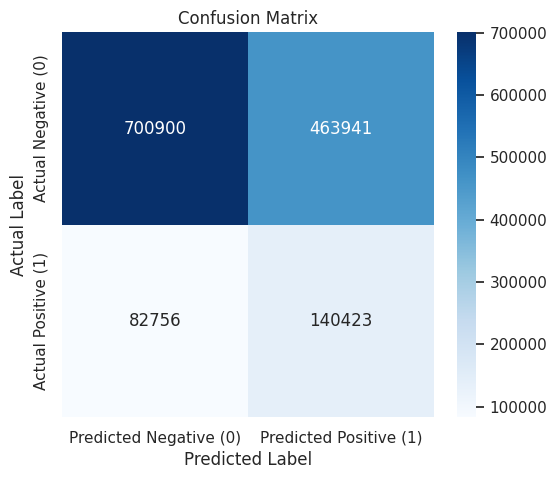

Precision: 0.23234838607196986
Recall: 0.6291945030670448
F1 Score: 0.3393733014477798
F2 Score: 0.4689896331525369
ROC AUC: 0.6154537632806192
PR AUC: 0.21908116633498875


In [0]:
# training best parameters on full 12m dataset
p = {
    "maxIter": 50,
    "layers": [511, 256, 128, 2],  # input, two hidden, output layer
    "blockSize": 128,
    "seed": 42
}

model_type = 'mlp'
pipeline = get_model(model_type, mlp_pipeline, p)

mlp_model_best_12m = pipeline.fit(df_train_downsampled.dropna().cache())

prediction_mlp_best_12m = mlp_model_best_12m.transform(df_test.dropna().cache())

precision_mlp_best_12m, recall_mlp_best_12m, f1_score_mlp_best_12m, f2_score_mlp_best_12m, roc_auc_mlp_best_12m, pr_auc_mlp_best_12m = evaluate_classification_model(prediction_mlp_best_12m, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_mlp_best_12m}")
print(f"Recall: {recall_mlp_best_12m}")
print(f"F1 Score: {f1_score_mlp_best_12m}")
print(f"F2 Score: {f2_score_mlp_best_12m}")
print(f"ROC AUC: {roc_auc_mlp_best_12m}")
print(f"PR AUC: {pr_auc_mlp_best_12m}")

## 5 Year Data
### Best Parameters MLP Model

In [0]:
# Read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

# Read the checkpointed 60m train and test datasets
df_train_downsampled = spark.read.parquet(f"{folder_path}/df_train_downsampled.parquet")
df_test = spark.read.parquet(f"{folder_path}/df_test.parquet")
df_train = spark.read.parquet(f"{folder_path}/df_train.parquet")

In [0]:
df_train_downsampled.dtypes

[('DEST', 'string'),
 ('ORIGIN', 'string'),
 ('OP_CARRIER_AIRLINE_ID', 'string'),
 ('ORIGIN_STATE_ABR', 'string'),
 ('DEST_STATE_ABR', 'string'),
 ('DEP_DEL15', 'int'),
 ('DIVERTED', 'string'),
 ('DISTANCE_GROUP', 'string'),
 ('MONTH', 'string'),
 ('origin_type', 'string'),
 ('dest_type', 'string'),
 ('dest_airport_lat', 'double'),
 ('dest_airport_lon', 'double'),
 ('sched_depart_date_time_UTC', 'timestamp'),
 ('HourlyDryBulbTemperature', 'double'),
 ('HourlyPrecipitation', 'double'),
 ('HourlyPressureChange', 'double'),
 ('HourlyPressureTendency', 'double'),
 ('HourlyRelativeHumidity', 'double'),
 ('HourlySeaLevelPressure', 'double'),
 ('HourlyStationPressure', 'double'),
 ('HourlyVisibility', 'double'),
 ('HourlyWindGustSpeed', 'double'),
 ('HourlyWindSpeed', 'double'),
 ('prev_flight_delay_ind', 'int'),
 ('is_holiday', 'int'),
 ('is_weekend', 'int'),
 ('origin_pagerank', 'double'),
 ('dest_pagerank', 'double')]

In [0]:
# Cross-fold Validation

from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd

class BlockedTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, df):
        return self.n_splits

    def split(self, df):
        """
        Splits the dataset into train and validation sets based on time blocks.
        df is assumed to be a PySpark DataFrame containing both features and the target column.
        """
        # Ensure the DataFrame has a column for time (e.g., 'timestamp' or 'date') for ordering
        df_sorted = df.orderBy('sched_depart_date_time_UTC')  # Change 'timestamp' to your actual time column

        # Get the time range or indices for the split
        n_samples = df_sorted.count()
        split_size = n_samples // self.n_splits
        
        for i in range(self.n_splits):
            start_idx = i * split_size
            stop_idx = start_idx + split_size
            mid_idx = start_idx + int(0.8 * (stop_idx - start_idx))  # 80% train, 20% validation

            # Train: First 80% of the block
            train_data = df_sorted.limit(mid_idx)

            # Validation: Remaining 20% of the block
            val_data = df_sorted.subtract(train_data).limit(stop_idx - mid_idx)

            yield train_data, val_data


def cross_validate_with_blocked_time_series_split(models, df, n_splits):
    
    evaluator = BinaryClassificationEvaluator(labelCol="DEP_DEL15") 
    
    # Initialize the blocked time series split
    splitter = BlockedTimeSeriesSplit(n_splits)
    
    # Initialize dictionary to store evaluation results
    results = {model_name: {
        "precision": [],
        "recall": [],
        "f1_score": [],
        "f2_score": [],
        "roc_auc": [],
        "pr_auc": []
    } for model_name in models.keys()}
    
    # Cross-validation loop for each model
    for model_name, model in models.items():
        # Perform split and evaluate for each fold
        for train_data, val_data in splitter.split(df):
            # Create a pipeline for training
            pipeline = get_model(model_name, mlp_pipeline, model)  
            
            # Train the model using training data
            trained_model = pipeline.fit(train_data)
            
            # Make predictions on validation data
            predictions = trained_model.transform(val_data)
            
            # Evaluate the model with binary classification evaluator
            precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_classification_model(predictions)
            
            # Store the evaluation metrics for each fold
            results[model_name]["precision"].append(precision)
            results[model_name]["recall"].append(recall)
            results[model_name]["f1_score"].append(f1_score)
            results[model_name]["f2_score"].append(f2_score)
            results[model_name]["roc_auc"].append(roc_auc)
            results[model_name]["pr_auc"].append(pr_auc)

        for metric in results[model_name]:
            # Calculate the average of the metric across all folds
            results[model_name][metric] = np.mean(results[model_name][metric])
        
    return results



In [0]:
#editing mlp_pipeline() to include new columns
def mlp_pipeline(model):
    """
    Optimized pipeline for neural network algorithms (MLP).
    """
    from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, FeatureHasher
    from pyspark.ml import Pipeline

    # Continuous features
    cont_feat = [
        'dest_airport_lat', 'dest_airport_lon', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
        'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
        'HourlyStationPressure', 'HourlyVisibility', 'HourlyWindGustSpeed', 
        'HourlyWindSpeed', 'origin_pagerank', 'dest_pagerank'
    ]

    assembler_cont = VectorAssembler(inputCols=cont_feat, outputCol="cont_features")

    #scale features with MinMaxScaler
    scaler = MinMaxScaler(inputCol="cont_features", outputCol="scaled_features")

    # Categorical features
    columns_categorical = [
        'OP_CARRIER_AIRLINE_ID', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 
        'DIVERTED', 'DISTANCE_GROUP', 'MONTH', 'origin_type', 'dest_type', 'prev_flight_delay_ind', 
        'is_holiday', 'is_weekend'
    ]

    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep") for c in columns_categorical]

    # Use FeatureHasher
    hasher = FeatureHasher(inputCols=[f"{c}_indexed" for c in columns_categorical], 
                           outputCol="hashed_features", numFeatures=500)

    # Assemble all features in one step
    assembler = VectorAssembler(inputCols=["scaled_features", "hashed_features"], outputCol="features")

    # Define pipeline stages
    stages = [assembler_cont, scaler] + indexers + [hasher, assembler, model]

    pipeline = Pipeline(stages=stages)

    return pipeline

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

def get_model(model_type, pipeline_func, p):
  """
  Input: name of model, the pipeline function for that model and a set of parameters
  Output: a pipeline object for the input model type
  """
  if model_type == 'mlp':
    mlp = MultilayerPerceptronClassifier(labelCol="DEP_DEL15",
        featuresCol="features",
        layers=p["layers"],
        maxIter=p["maxIter"],
        blockSize=p["blockSize"],
        seed=p["seed"])
    pipeline = pipeline_func(mlp)
    
  return pipeline

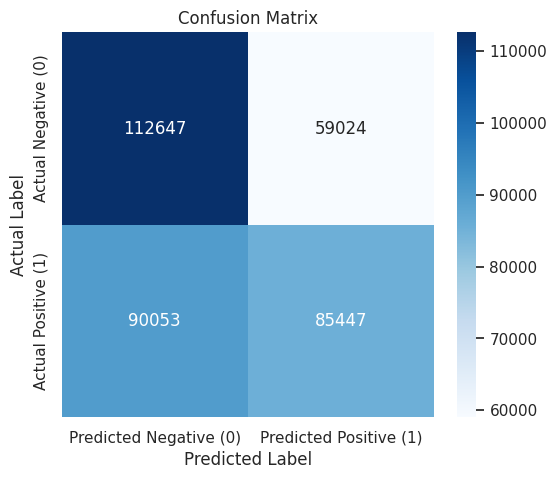

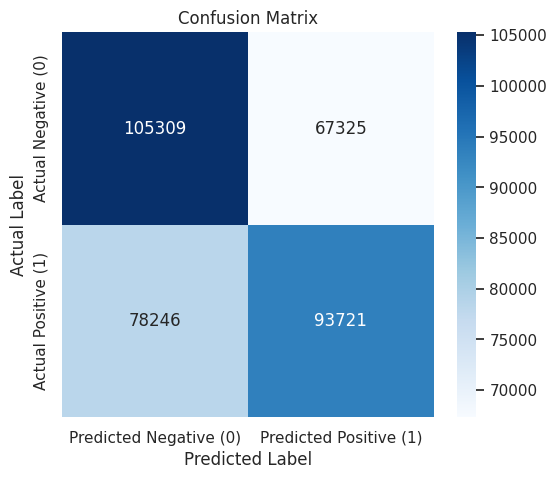

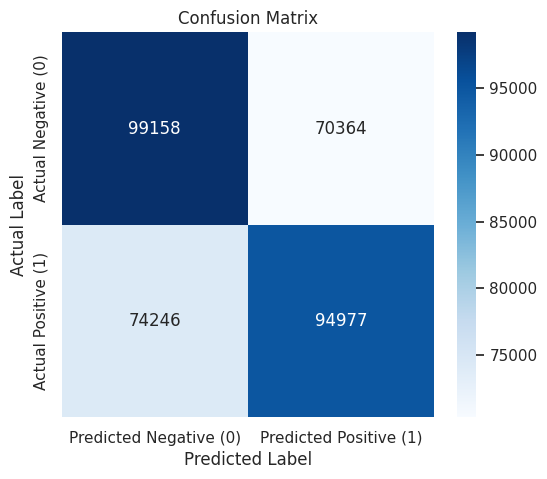

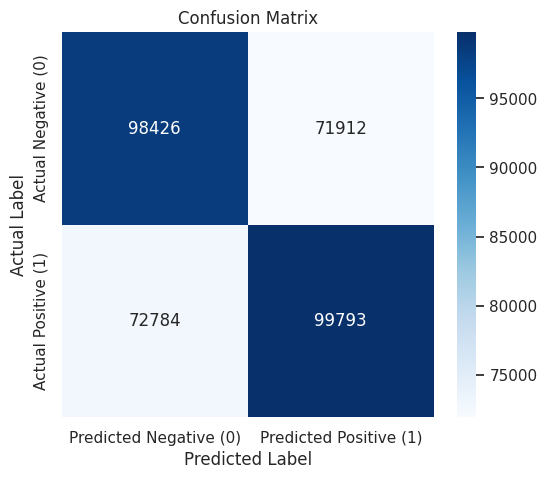

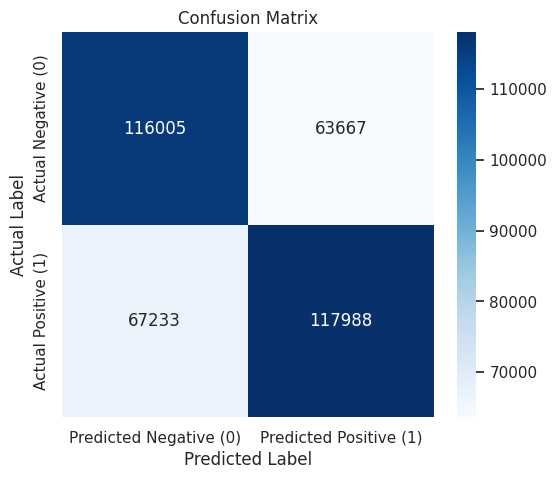

{'mlp': {'precision': 0.5957071582881535, 'recall': 0.5616778226006229, 'f1_score': 0.5775290403483514, 'f2_score': 0.5677763774247918, 'roc_auc': 0.5734945287119269, 'pr_auc': 0.5592667913912985}}


In [0]:
#Cross Validation
p = {
    "maxIter": 50,
    "layers": [513, 256, 128, 2],  # input (+2 new cont columns), two hidden, output layer
    "blockSize": 128,
    "seed": 42
}

models = {'mlp': p}

#'df_train' is the full dataframe containing both features and target columns
# Perform cross-validation
df_train_downsampled = df_train_downsampled.dropna().cache()
results = cross_validate_with_blocked_time_series_split(models, df_train_downsampled, n_splits=5)

print(results)

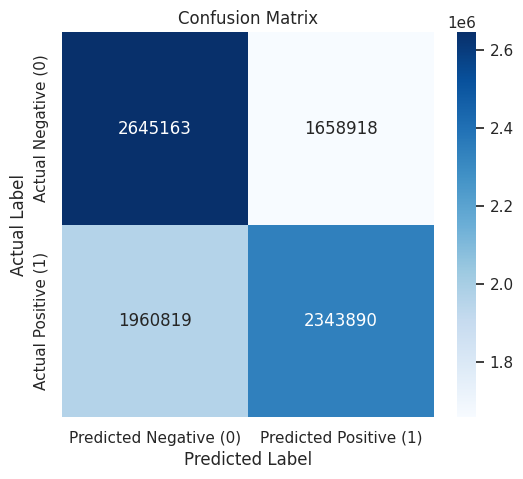

Precision: 0.5855614358720178
Recall: 0.5444944129789029
F1 Score: 0.5642817222041194
F2 Score: 0.5522404390536378
ROC AUC: 0.5795326641748435
PR AUC: 0.5660828869699792


In [0]:
#training on full 60m dataset
p = {
    "maxIter": 50,
    "layers": [513, 256, 128, 2],  # input, two hidden, output layer
    "blockSize": 128,
    "seed": 42
}

model_type = 'mlp'
pipeline = get_model(model_type, mlp_pipeline, p)

mlp_model_60m = pipeline.fit(df_train_downsampled.dropna().cache())

train_predictions = mlp_model_60m.transform(df_train_downsampled.dropna().cache())

precision_train, recall_train, f1_score_train, f2_score_train, roc_auc_train, pr_auc_train = evaluate_classification_model(train_predictions, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_score_train}")
print(f"F2 Score: {f2_score_train}")
print(f"ROC AUC: {roc_auc_train}")
print(f"PR AUC: {pr_auc_train}")

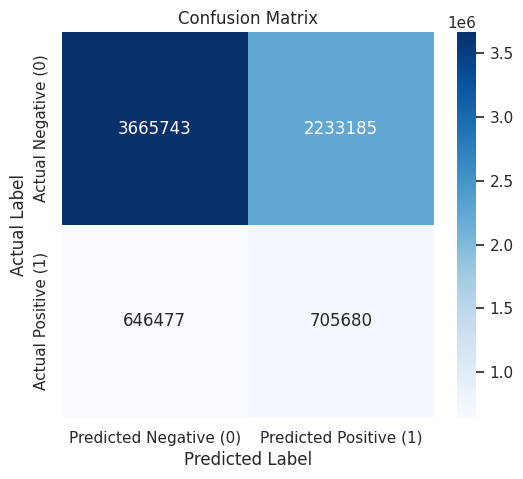

Precision: 0.2401199102374556
Recall: 0.5218920583926275
F1 Score: 0.3289099892752822
F2 Score: 0.4226897824292875
ROC AUC: 0.5716586705440297
PR AUC: 0.22729624159512363


In [0]:
#fitting test dataset
prediction_mlp_60m = mlp_model_60m.transform(df_test.dropna().cache())

precision_mlp_60m, recall_mlp_60m, f1_score_mlp_60m, f2_score_mlp_60m, roc_auc_mlp_60m, pr_auc_mlp_60m = evaluate_classification_model(prediction_mlp_60m, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_mlp_60m}")
print(f"Recall: {recall_mlp_60m}")
print(f"F1 Score: {f1_score_mlp_60m}")
print(f"F2 Score: {f2_score_mlp_60m}")
print(f"ROC AUC: {roc_auc_mlp_60m}")
print(f"PR AUC: {pr_auc_mlp_60m}")

## Test Code

In [0]:
#introducing early stopping by tuning maxIter with cross validation
#also increased the block size due to the larger volume of data
#MLP Model Tuning
param_grid = {
    "layers": [
        [513, 256, 128, 2],
    ],
    "maxIter": [5, 10, 15, 25, 50],
    "blockSize": [1024, 2048],
    "seed": [42]
}

best_parameters, best_score = timeSeriesSplitCV(df_train_downsampled.dropna().cache(), param_grid=param_grid, pipeline_func=mlp_pipeline, model_type='mlp', k=5, blocking=True ,metric='f2')


Number of total chunks: 30, each chunk has ~286,959 rows
************************************************************
Parameters: {'layers': [513, 256, 128, 2], 'maxIter': 5, 'blockSize': 1024, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 06:55:00 to 2015-07-15 12:40:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 1 goes from 2015-07-15 12:40:00 to 2015-08-30 19:35:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 1 is 1,147,836 with a f2 score of 0.76
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-08-30 19:35:00 to 2016-04-10 10:20:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 2 goes from 2016-04-10 10:20:00 to 2016-06-05 12:15:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 2 is 1,147,836 with a f2 score of 0.21
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2016-06-05 12:15:00 to 2016-12-28 23:05:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 3 goes from 2016-12-28 23:05:00 to 2017-02-22 01:00:00, count is 286,959 flights
    Number of training datapoints for fold 3 is 1,147,836 with a f2 score of 0.61
------------------------------------------------------------
    TRAIN set for fold 4 goes from 2017-02-22 01:00:00 to 2017-09-04 12:35:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 4 goes from 2017-09-04 12:37:00 to 2017-10-31 23:20:00, count is 286,959 flights
    Number of training datapoints for fold 4 is 1,147,836 with a f2 score of 0.70
------------------------------------------------------------
    TRAIN set for fold 5 goes from 2017-10-31 23:20:00 to 2018-05-08 20:56:00, count is 1,147,836 flights (no sampling)
    DEV

/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 1 is 1,147,836 with a f2 score of 0.72
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-08-30 19:35:00 to 2016-04-10 10:20:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 2 goes from 2016-04-10 10:20:00 to 2016-06-05 12:15:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 2 is 1,147,836 with a f2 score of 0.20
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2016-06-05 12:15:00 to 2016-12-28 23:05:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 3 goes from 2016-12-28 23:05:00 to 2017-02-22 01:00:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 3 is 1,147,836 with a f2 score of 0.44
------------------------------------------------------------
    TRAIN set for fold 4 goes from 2017-02-22 01:00:00 to 2017-09-04 12:35:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 4 goes from 2017-09-04 12:37:00 to 2017-10-31 23:20:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 4 is 1,147,836 with a f2 score of 0.67
------------------------------------------------------------
    TRAIN set for fold 5 goes from 2017-10-31 23:20:00 to 2018-05-08 20:56:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 5 goes from 2018-05-08 20:56:00 to 2018-06-16 02:40:00, count is 286,959 flights
    Number of training datapoints for fold 5 is 1,147,836 with a f2 score of 0.27
------------------------------------------------------------
Result was no better, score was 0.46 with best f2 score 0.51
************************************************************
Parameters: {'layers': [513, 256, 128, 2], 'maxIter': 10, 'blockSize': 2048, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 06:55:00 to 2015-07-15 12:40:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 1 goes from 2015-07-15 12:40:00 to 2015-08-30 19:35:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 1 is 1,147,836 with a f2 score of 0.72
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-08-30 19:35:00 to 2016-04-10 10:20:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 2 goes from 2016-04-10 10:20:00 to 2016-06-05 12:15:00, count is 286,959 flights
    Number of training datapoints for fold 2 is 1,147,836 with a f2 score of 0.20
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2016-06-05 12:15:00 to 2016-12-28 23:05:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 3 goes from 2016-12-28 23:05:00 to 2017-02-22 01:00:00, count is 286,959 flights
    Number of training datapoints for fold 3 is 1,147,836 with a f2 score of 0.44
------------------------------------------------------------
    TRAIN set for fold 4 goes from 2017-02-22 01:00:00 to 2017-09-04 12:35:00, count is 1,147,836 flights (no sampling)
    DEV

/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 1 is 1,147,836 with a f2 score of 0.73
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-08-30 19:35:00 to 2016-04-10 10:20:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 2 goes from 2016-04-10 10:20:00 to 2016-06-05 12:15:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 2 is 1,147,836 with a f2 score of 0.04
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2016-06-05 12:15:00 to 2016-12-28 23:05:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 3 goes from 2016-12-28 23:05:00 to 2017-02-22 01:00:00, count is 286,959 flights
    Number of training datapoints for fold 3 is 1,147,836 with a f2 score of 0.04
------------------------------------------------------------
    TRAIN set for fold 4 goes from 2017-02-22 01:00:00 to 2017-09-04 12:35:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 4 goes from 2017-09-04 12:37:00 to 2017-10-31 23:20:00, count is 286,959 flights
    Number of training datapoints for fold 4 is 1,147,836 with a f2 score of 0.59
------------------------------------------------------------
    TRAIN set for fold 5 goes from 2017-10-31 23:20:00 to 2018-05-08 20:56:00, count is 1,147,836 flights (no sampling)
    DEV

/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 4 is 1,147,836 with a f2 score of 0.09
------------------------------------------------------------
    TRAIN set for fold 5 goes from 2017-10-31 23:20:00 to 2018-05-08 20:56:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 5 goes from 2018-05-08 20:56:00 to 2018-06-16 02:40:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 5 is 1,147,836 with a f2 score of 0.04
------------------------------------------------------------
Result was no better, score was 0.14 with best f2 score 0.51
************************************************************
Parameters: {'layers': [513, 256, 128, 2], 'maxIter': 50, 'blockSize': 1024, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 06:55:00 to 2015-07-15 12:40:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 1 goes from 2015-07-15 12:40:00 to 2015-08-30 19:35:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 1 is 1,147,836 with a f2 score of 0.59
------------------------------------------------------------
    TRAIN set for fold 2 goes from 2015-08-30 19:35:00 to 2016-04-10 10:20:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 2 goes from 2016-04-10 10:20:00 to 2016-06-05 12:15:00, count is 286,959 flights
    Number of training datapoints for fold 2 is 1,147,836 with a f2 score of 0.43
------------------------------------------------------------
    TRAIN set for fold 3 goes from 2016-06-05 12:15:00 to 2016-12-28 23:05:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 3 goes from 2016-12-28 23:05:00 to 2017-02-22 01:00:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 3 is 1,147,836 with a f2 score of 0.38
------------------------------------------------------------
    TRAIN set for fold 4 goes from 2017-02-22 01:00:00 to 2017-09-04 12:35:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 4 goes from 2017-09-04 12:37:00 to 2017-10-31 23:20:00, count is 286,959 flights


/databricks/spark/python/pyspark/sql/context.py:164: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    Number of training datapoints for fold 4 is 1,147,836 with a f2 score of 0.48
------------------------------------------------------------
    TRAIN set for fold 5 goes from 2017-10-31 23:20:00 to 2018-05-08 20:56:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 5 goes from 2018-05-08 20:56:00 to 2018-06-16 02:40:00, count is 286,959 flights
    Number of training datapoints for fold 5 is 1,147,836 with a f2 score of 0.44
------------------------------------------------------------
Result was no better, score was 0.46 with best f2 score 0.51
************************************************************
Parameters: {'layers': [513, 256, 128, 2], 'maxIter': 50, 'blockSize': 2048, 'seed': 42}
    TRAIN set for fold 1 goes from 2015-01-01 06:55:00 to 2015-07-15 12:40:00, count is 1,147,836 flights (no sampling)
    DEV set for fold 1 goes from 2015-07-15 12:40:00 to 2015-08-30 19:35:00, count is 286,959 flights
    Number of training datapoints for fold 1 is 1,147,836 w

In [0]:
print(f"Best parameters: {best_parameters}")
print(f"Best score: {best_score}")

Best parameters: {'layers': [513, 256, 128, 2], 'maxIter': 5, 'blockSize': 2048, 'seed': 42}
Best score: 0.51126


In [0]:
# Cross-fold Validation

from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd

class BlockedTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, df):
        return self.n_splits

    def split(self, df):
        df_sorted = df.orderBy('sched_depart_date_time_UTC').cache()
        timestamps = df_sorted.select("sched_depart_date_time_UTC").rdd.map(lambda r: r[0]).collect()
        n_samples = len(timestamps)
        split_size = n_samples // self.n_splits

        for i in range(self.n_splits):
            start_idx = i * split_size
            stop_idx = min(start_idx + split_size, n_samples)
            mid_idx = start_idx + int(0.8 * (stop_idx - start_idx))

            train_start = timestamps[start_idx]
            train_end = timestamps[mid_idx - 1]
            val_start = timestamps[mid_idx]
            val_end = timestamps[stop_idx - 1]

            train_data = df.filter((F.col("sched_depart_date_time_UTC") >= train_start) &
                                (F.col("sched_depart_date_time_UTC") <= train_end)).cache()

            val_data = df.filter((F.col("sched_depart_date_time_UTC") > train_end) &
                                (F.col("sched_depart_date_time_UTC") <= val_end)).cache()

            yield train_data, val_data


def cross_validate_with_blocked_time_series_split(models, df, n_splits):
    
    evaluator = BinaryClassificationEvaluator(labelCol="DEP_DEL15") 
    
    # Initialize the blocked time series split
    splitter = BlockedTimeSeriesSplit(n_splits)
    
    # Initialize dictionary to store evaluation results
    results = {model_name: {
        "precision": [],
        "recall": [],
        "f1_score": [],
        "f2_score": [],
        "roc_auc": [],
        "pr_auc": []
    } for model_name in models.keys()}
    
    # Cross-validation loop for each model
    for model_name, model in models.items():
        # Perform split and evaluate for each fold
        for train_data, val_data in splitter.split(df):
            # Create a pipeline for training
            pipeline = get_model(model_name, mlp_pipeline, model)  
            
            # Train the model using training data
            trained_model = pipeline.fit(train_data)
            
            # Make predictions on validation data
            predictions = trained_model.transform(val_data)
            
            # Evaluate the model with binary classification evaluator
            precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_classification_model(predictions)
            
            # Store the evaluation metrics for each fold
            results[model_name]["precision"].append(precision)
            results[model_name]["recall"].append(recall)
            results[model_name]["f1_score"].append(f1_score)
            results[model_name]["f2_score"].append(f2_score)
            results[model_name]["roc_auc"].append(roc_auc)
            results[model_name]["pr_auc"].append(pr_auc)

        for metric in results[model_name]:
            # Calculate the average of the metric across all folds
            results[model_name][metric] = np.mean(results[model_name][metric])
        
    return results

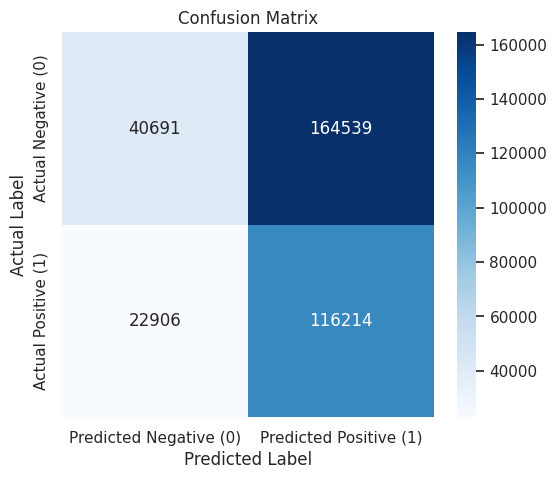

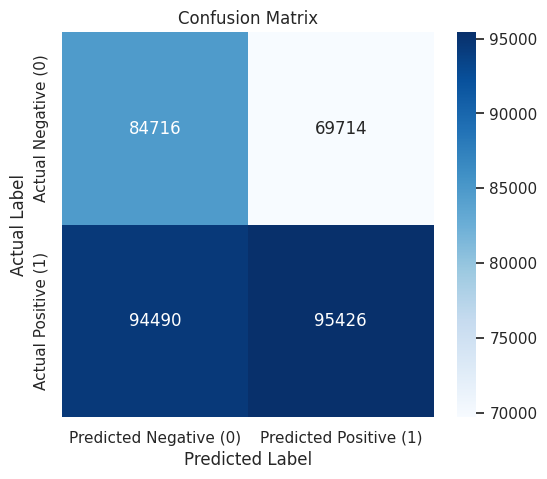

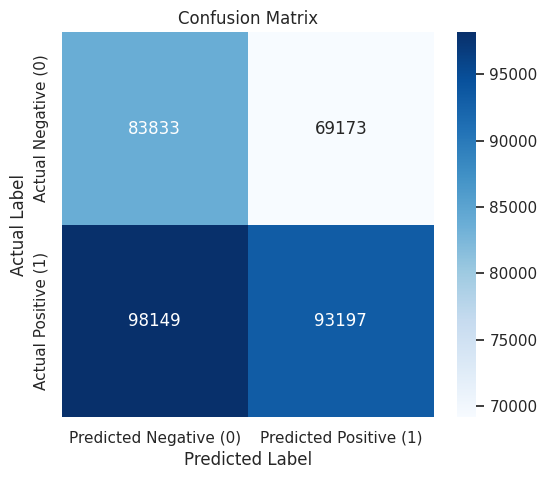

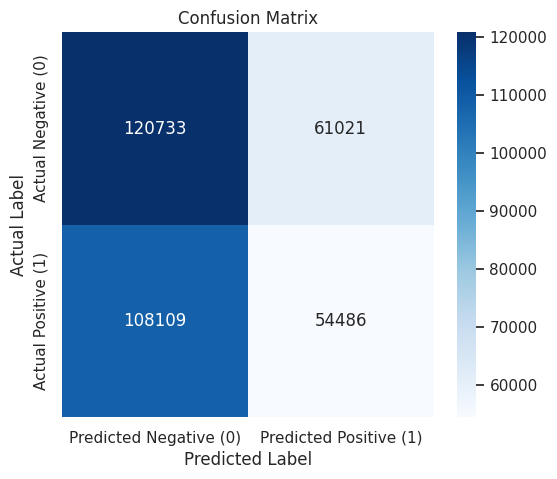

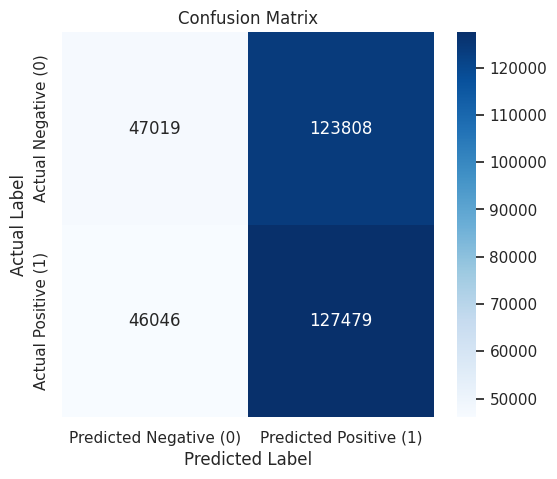

{'mlp': {'precision': 0.508956230972481, 'recall': 0.5789242184650518, 'f1_score': 0.522012369741903, 'f2_score': 0.5484310099905869, 'roc_auc': 0.5128879473152501, 'pr_auc': 0.5064852703372508}}


In [0]:
#Cross Validation on 60m for best parameters
p = {'layers': [513, 256, 128, 2], 'maxIter': 5, 'blockSize': 2048, 'seed': 42}

models = {'mlp': p}

#'df_train' is the full dataframe containing both features and target columns
# Perform cross-validation
df_train_downsampled = df_train_downsampled.dropna().cache()
results = cross_validate_with_blocked_time_series_split(models, df_train_downsampled, n_splits=5)

print(results)

In [0]:
#training on full dataset
model_type = 'mlp'
pipeline = get_model(model_type, mlp_pipeline, p)

mlp_model_60m = pipeline.fit(df_train_downsampled.dropna().cache())


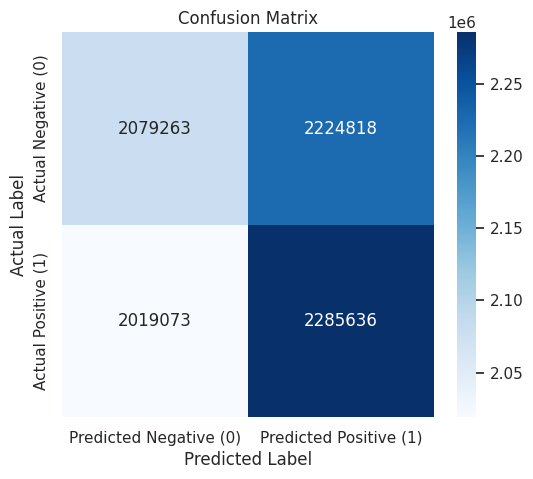

Precision: 0.5067418933881157
Recall: 0.5309617909131604
F1 Score: 0.51856919718898
F2 Score: 0.5259343494426187
ROC AUC: 0.507026419344258
PR AUC: 0.5051693445191763


In [0]:
train_predictions = mlp_model_60m.transform(df_train_downsampled.dropna().cache())

precision_train, recall_train, f1_score_train, f2_score_train, roc_auc_train, pr_auc_train = evaluate_classification_model(train_predictions, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_score_train}")
print(f"F2 Score: {f2_score_train}")
print(f"ROC AUC: {roc_auc_train}")
print(f"PR AUC: {pr_auc_train}")

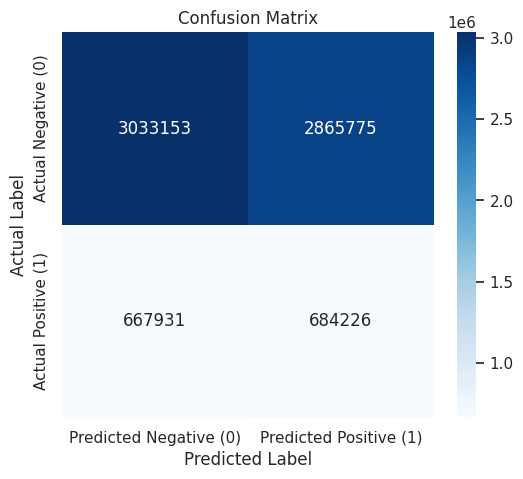

Precision: 0.19273966401699605
Recall: 0.5060255576830205
F1 Score: 0.2791529771174246
F2 Score: 0.38188097754689915
ROC AUC: 0.5101063558439758
PR AUC: 0.19119274417567425


In [0]:
#fitting test dataset
prediction_mlp_60m = mlp_model_60m.transform(df_test.dropna().cache())

precision_mlp_60m, recall_mlp_60m, f1_score_mlp_60m, f2_score_mlp_60m, roc_auc_mlp_60m, pr_auc_mlp_60m = evaluate_classification_model(prediction_mlp_60m, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_mlp_60m}")
print(f"Recall: {recall_mlp_60m}")
print(f"F1 Score: {f1_score_mlp_60m}")
print(f"F2 Score: {f2_score_mlp_60m}")
print(f"ROC AUC: {roc_auc_mlp_60m}")
print(f"PR AUC: {pr_auc_mlp_60m}")

In [0]:
def upsample(train_df,verbose=False):
  '''Upsamples train_df to balance classes'''
  #balance classes in train
  delay_count = train_df.filter(F.col("DEP_DEL15") == 1).count()
  non_delay_count = train_df.filter(F.col("DEP_DEL15") == 0).count()
 
  total = delay_count + non_delay_count
  keep_percent = non_delay_count / delay_count
 
  train_delay = train_df.filter(F.col('DEP_DEL15') == 0)
  train_non_delay = train_df.filter(F.col('DEP_DEL15') == 1).sample(withReplacement=True, fraction=keep_percent,seed=42)
  train_upsampled = train_delay.union(train_non_delay)
  return train_upsampled
 
def downsample(train_df,verbose=False):
  '''Downsamples train_df to balance classes'''
  #balance classes in train
  delay_count = train_df.filter(F.col("DEP_DEL15") == 1).count()
  non_delay_count = train_df.filter(F.col("DEP_DEL15") == 0).count()
 
  total = delay_count + non_delay_count
  keep_percent = delay_count / non_delay_count
  
  train_delay = train_df.filter(F.col('DEP_DEL15') == 1)
  train_non_delay = train_df.filter(F.col('DEP_DEL15') == 0).sample(withReplacement=False,fraction=keep_percent,seed=42)
  train_downsampled = train_delay.union(train_non_delay)
  return train_downsampled

def add_class_weights(train_df,verbose=False):
  """Add class weight to balance classes"""
  delay_count = train_df.filter(F.col("DEP_DEL15") == 1).count()
  sample_ratio = delay_count.count()/ train_df.count() 
  late_weight = 1-sample_ratio
  ontime_weight = sample_ratio
  weighted_df = train_df.withColumn("delay_weight", when(train_df.DEP_DEL15 == 1, late_weight)
                              .otherwise(ontime_weight))
  
  print('For class weights determination, the fraction of positives in the dataset is %.3f' %sample_ratio)
  return weighted_df